## LinearRegressionArchitecture_Workshop
Chao-Chung ,Liu

## 📂 Project Structure Overview

This project follows the **MLOps (Machine Learning Operations)** architectural patterns to ensure reproducibility and modularity.

| Directory / File | Description |
| :--- | :--- |
| **`data/raw/`** | **Raw Data**: Stores immutable original CSV files (e.g., `RMBR4-2_export_test.csv`). These files should never be edited manually. |
| **`data/processed/`** | **Processed Data**: Stores cleaned and transformed datasets ready for model training. |
| **`notebooks/`** | **Jupyter Notebooks**: `EDA.ipynb` for data exploration; `linear_regression.ipynb` for model prototyping. |
| **`src/`** | **Source Code**: Modular Python scripts for data loading, preprocessing, model definition, and evaluation. |
| **`configs/`** | **Configurations**: YAML files to manage experiment parameters (e.g., learning rates, paths) without changing code. |
| **`experiments/`** | **Experiment Tracking**: Automatically logs performance metrics (e.g., RMSE, R² scores) for each run. |
| **`requirements.txt`** | **Dependencies**: Lists all Python packages required to run the project. |
| **`README.md`** | **Documentation**: Summary of work, design decisions, and step-by-step instructions. |

## 🌐1.import selfmod

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.abspath('../'))

from src.data_loader import load_from_csv, load_from_db, load_config
from src.preprocessing import clean_robot_data, apply_smoothing, prepare_features
from src.model import ManualLinearRegression
from src.evaluation import evaluate_model, plot_regression_results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import matplotlib.pyplot as plt


## 🌐2.Manual Implementation

def Hypothesis Function & Cost Function

* Hypothesis Function : It is the mathematical formula that the model uses to make predictions. In linear regression, we assume a linear relationship between the input features $x$ and the output $y$.

    ### Mathematical Formula: $h_\theta(x) = \theta_0 + \theta_1 x$

        $\theta_0$: The Intercept, representing the predicted value when $x=0$.

        $\theta_1$: The Slope, representing the change in $y$ for every unit change in $x$.

        In your robot project: $x$ is "Time" and $y$ is "Predicted Current."

* Cost Function : An indicator that measures how "inaccurate" the model's predictions are. A lower cost function value means the predictions are closer to the actual data. The most common method is Mean Squared Error (MSE).

    ### Mathematical Formula: $J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2$

        It calculates the difference between "Predictions" and "Actual Values," squares them (to remove signs and amplify errors).

        $m$ represents the number of data points.

        Our goal is to find the parameters $\theta$ that minimize $J(\theta)$.

In [2]:
def hypothesis(theta, X):

    # Hypothesis Function: h(x) = theta0 + theta1 * x

    return np.dot(X, theta)

def compute_cost(X, y, theta):

    # Cost Function (Mean Squared Error)
    # J(theta) = (1/2m) * sum((h(x) - y)^2)

    m = len(y)
    predictions = hypothesis(theta, X)
    cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
    return cost

## 🌐3.Gradient Descent

In [3]:
def gradient_descent(X, y, theta, learning_rate, iterations):

    # Gradient Descent Algorithm

    m = len(y)
    cost_history = []

    for i in range(iterations):
        predictions = hypothesis(theta, X)
        # Update rule
        errors = predictions - y
        gradient = (1 / m) * np.dot(X.T, errors)
        theta = theta - learning_rate * gradient
        
        # Record cost for each iteration
        cost_history.append(compute_cost(X, y, theta))
        
    return theta, cost_history

* Hypothesis Function is responsible for "guessing" the answer.
* Cost Function is responsible for "grading," telling the model how well it guessed.
* The subsequent Gradient Descent then "corrects" the $\theta$ in the hypothesis function based on the grade, until the grade is highest (cost is lowest).

## 🌐4.Data Preparation
Read the data, and convert the data into matrix format.

In [4]:
# Load and clean
df_processed = load_from_csv('../data/processed/cleaned_data.csv')

# Independent variable(IV) X and Dependent variable(DV) y
# predict 'Axis1_smooth' using 'Elapsed_Seconds'
X = df_processed[['Elapsed_Seconds']].values
y = df_processed['Axis1_Smooth'].values

# Feature Scaling
X_mean = np.mean(X)
X_std = np.std(X)
X_scaled = (X - X_mean) / X_std

# Add a column of ones for theta0
X_final = np.c_[np.ones(X_scaled.shape[0]), X_scaled]

# Initialize parameters
theta_initial = np.zeros(2) # [theta0, theta1]

✅ CSV Loaded: ../data/processed/cleaned_data.csv


## 🌐5.Model Training
Find the optimal  $\theta$

In [5]:
# Set hyperparameters
learning_rate = 0.01
iterations = 1000

#  Run Gradient Descent
theta_final, cost_history = gradient_descent(X_final, y, theta_initial, learning_rate, iterations)

print(f"Training Complete!")
print(f"Final Theta: {theta_final}")
print(f"Final Cost: {cost_history[-1]}")

Training Complete!
Final Theta: [ 0.7259402  -0.00237765]
Final Cost: 0.199134063520453


## 🌐6.Visualizing Results

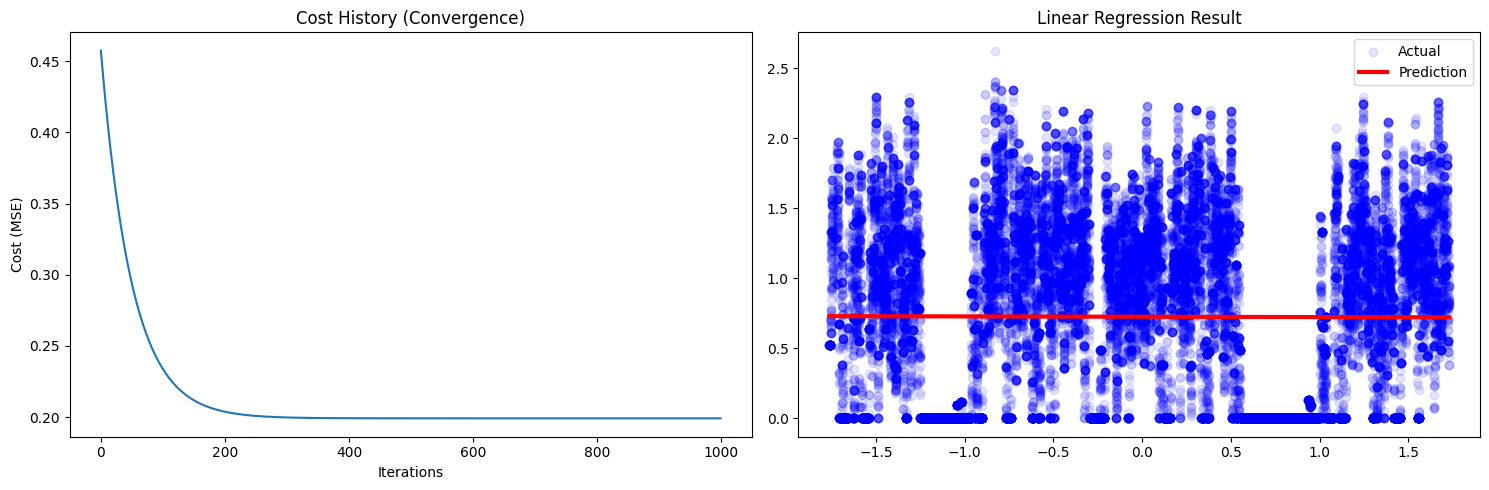

In [6]:
plt.figure(figsize=(15, 5))

# A：Cost History
plt.subplot(1, 2, 1)
plt.plot(cost_history)
plt.title("Cost History (Convergence)")
plt.xlabel("Iterations")
plt.ylabel("Cost (MSE)")

# B：Regression Line vs Data
plt.subplot(1, 2, 2)
plt.scatter(X_scaled, y, color='blue', alpha=0.1, label='Actual')
plt.plot(X_scaled, hypothesis(theta_final, X_final), color='red', linewidth=3, label='Prediction')
plt.title("Linear Regression Result")
plt.legend()

plt.tight_layout()
plt.show()

## 🌐7.RMSE & $R^2$ 

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

# Get predictions from our manual model
y_pred = hypothesis(theta_final, X_final)

# Calculate RMSE
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

# Calculate a variation of Axis1_Smooth
axis1_smooth_variation = df_processed['Axis1_Smooth'].max() - df_processed['Axis1_Smooth'].min()

print(f"Variation of Axis1_Smooth current: {axis1_smooth_variation:.4f}")
# Calculate R2 Score
r2 = r2_score(y, y_pred)

# Calculate Adjusted R2 Score
n = len(y)  # Number of observations
p = X_final.shape[1] - 1  # Number of predictors (excluding the intercept)
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

print(f"--- Model Evaluation ---")
print(f"RMSE: {rmse:.4f} (The average prediction error is approximately {rmse:.4f})")
print(f"R2 Score: {r2:.4f}")
print(f"Adjusted R2 Score: {adjusted_r2:.4f}")

Variation of Axis1_Smooth current: 2.6267
--- Model Evaluation ---
RMSE: 0.6311 (The average prediction error is approximately 0.6311)
R2 Score: 0.0000
Adjusted R2 Score: -0.0000


## Interpretation: R² and RMSE Interpretation

### R² Score

The model obtained an R² value close to **0.00**, which indicates that the regression does not explain the variability of the smoothed current signal (Axis1_Smooth).

In practical terms, this means that the model performs no better than simply predicting the average current value for all time points. The linear relationship between time and current is therefore very weak or nonexistent.

This result is consistent with the observed cyclic behavior of the current signal, which does not follow a linear trend.

---

### RMSE (Root Mean Squared Error)

The RMSE obtained was approximately: **RMSE ≈ 0.63**

This means that the average prediction error represents a significant portion of the natural variability of the data.

Although the RMSE value may not appear extremely large in isolation, the combination of:

- Low R² (≈ 0)
- Moderate RMSE relative to data variation

indicates that the model is not capturing the underlying pattern of the signal.

### Conclusion

The linear regression model is not suitable for directly modeling the smoothed current signal due to its cyclic and non-linear behavior.

## 🌐8.Problem Reformulation: Analyzing Current Peaks in Cyclic Variations

The analysis showed that the smoothed current signal presents a clear cyclic pattern, characterized by repeated peaks and drops over time. This behavior indicates that the relationship between time and instantaneous current is not linear, which explains the low R² values obtained from direct linear regression.

Although the problem is not suitable for linear regression, we can still analyze the peaks of the current signal within fixed time windows of the cyclic variation. These peaks represent the maximum mechanical and electrical stress experienced by the robot during each cycle, making them valuable indicators of system performance and potential failure.

By extracting peak current values over fixed time windows or operational cycles, we can transform the signal into a more stable trend that reflects long-term changes in system behavior. This allows us to define:

1. **Failure Threshold**: A critical limit for the peak current, beyond which the robot is expected to fail.
2. **Alert Threshold**: A warning level to notify when the system is approaching the failure threshold.

This approach provides a more realistic and physically meaningful method for fault prediction compared to direct regression on the raw or smoothed current signal. It enables proactive maintenance by identifying abnormal trends in peak currents and triggering alerts before failure occurs.

### Extracting the Peak

This section of the code focuses on analyzing the smoothed current signal (`Axis1_Smooth`) by dividing the data into fixed time windows and extracting the peak current values for each window.

This process transforms the raw smoothed current signal into a more structured format, enabling further analysis of peak currents over time windows. This is particularly useful for identifying trends and anomalies in the robot's operation.

In [8]:
import pandas as pd

TIME_COL = "Elapsed_Seconds"
SIGNAL_COL = "Axis1_Smooth"

WINDOW_SIZE = 30  # seconds

# Create window index (0,1,2,3,...)
df_processed["window_id"] = (df_processed[TIME_COL] // WINDOW_SIZE).astype(int)

# Extract peak current per window
peaks_df = (
    df_processed.groupby("window_id")
      .agg({
          TIME_COL: "max",        # end time of window
          SIGNAL_COL: "max"       # peak current
      })
      .reset_index(drop=True)
)

# Rename columns for clarity
peaks_df = peaks_df.rename(columns={
    TIME_COL: "window_end_time",
    SIGNAL_COL: "peak_current"
})

# Show result
display(peaks_df.head(10))
print("Number of windows:", len(peaks_df))
print(peaks_df.describe())


,window_end_time,peak_current
0,28.204,0.521698
1,58.345,0.521698
2,89.609,0.521698
3,119.657,0.521698
4,149.265,0.521698
5,179.907,0.788019
6,208.615,0.765609
7,239.311,1.334733
8,269.373,1.334733
9,299.921,1.705290


Number of windows: 2671
       window_end_time  peak_current
count      2671.000000   2671.000000
mean      40754.197736      0.831368
std       23160.135347      0.685719
min          28.204000      0.000000
25%       20741.437500      0.000000
50%       40769.049000      0.930822
75%       60793.713000      1.382160
max       80794.968000      2.626731


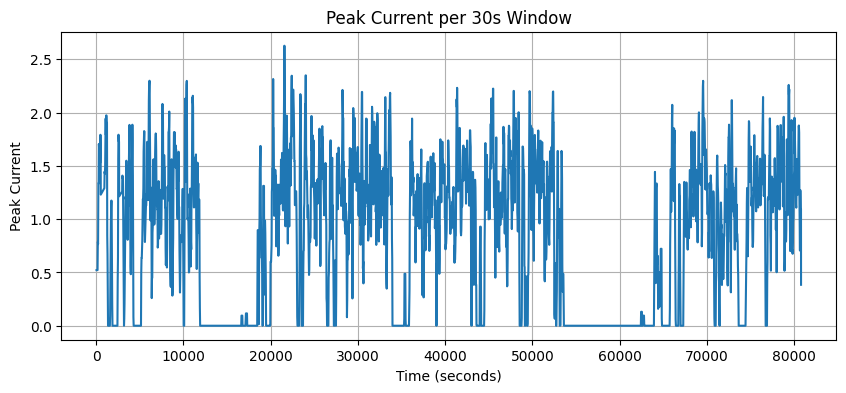

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(peaks_df["window_end_time"], peaks_df["peak_current"])
plt.xlabel("Time (seconds)")
plt.ylabel("Peak Current")
plt.title("Peak Current per 30s Window")
plt.grid(True)
plt.show()


The below section of the code identifies baseline behavior and calculates thresholds for detecting anomalies in the robot's operation. Here's a detailed explanation: (MinC / MaxC)

1. **Define Normal Operation**:
   - The first 25% of the data is considered as the "normal operation" period. This ratio can be adjusted (e.g., 20-30%) depending on the dataset and operational characteristics.
   - The number of baseline windows is calculated as 25% of the total number of windows in the `peaks_df` DataFrame.
   - The peak current values for these baseline windows are extracted into the `normal_peaks` variable.

2. **Baseline Statistics**:
   - The number of baseline windows and descriptive statistics (e.g., mean, standard deviation, min, max) for the `normal_peaks` are printed. These statistics provide insights into the typical behavior of the system during normal operation.

3. **Threshold Calculation**:
   - Two thresholds are calculated based on the distribution of the baseline peak current values:
     - **Alert Threshold (MinC)**: The 95th percentile of the baseline peak currents. If the peak current exceeds this value, it indicates a potential issue that requires attention.
     - **Error Threshold (MaxC)**: The 99th percentile of the baseline peak currents. If the peak current exceeds this value, it indicates a critical issue that may lead to system failure.

These thresholds are essential for implementing an effective anomaly detection system, enabling the identification of abnormal behavior and triggering alerts or maintenance actions before failures occur.

In [10]:
# Use first portion of data as "normal operation"
NORMAL_RATIO = 0.25   # first 25% of windows (you can adjust 20-30%)

n_normal = int(len(peaks_df) * NORMAL_RATIO)

normal_peaks = peaks_df.iloc[:n_normal]["peak_current"]

print("Number of baseline windows:", len(normal_peaks))
print("Baseline stats:")
print(normal_peaks.describe())

# Calculate thresholds
MinC = np.percentile(normal_peaks, 95)   # Alert threshold
MaxC = np.percentile(normal_peaks, 99)   # Error threshold

print("\nThresholds:")
print("Alert threshold (MinC):", MinC)
print("Error threshold (MaxC):", MaxC)


Number of baseline windows: 667
Baseline stats:
count    667.000000
mean       0.648330
std        0.684175
min        0.000000
25%        0.000000
50%        0.507105
75%        1.239097
max        2.314545
Name: peak_current, dtype: float64

Thresholds:
Alert threshold (MinC): 1.8153101799999998
Error threshold (MaxC): 2.1447676800000006


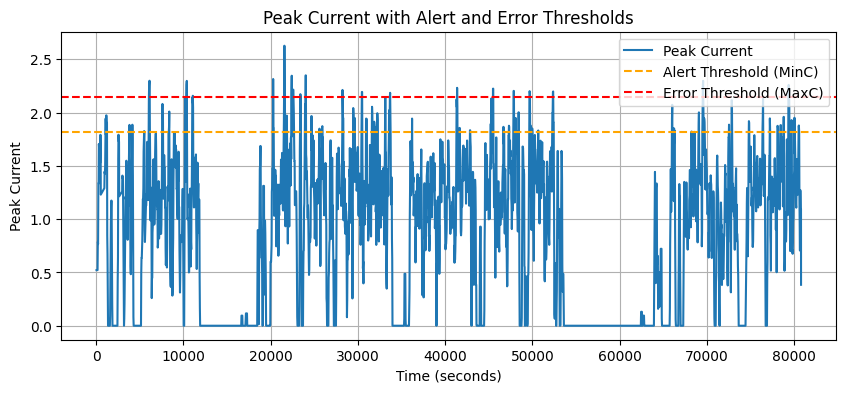

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(peaks_df["window_end_time"], peaks_df["peak_current"], label="Peak Current")

plt.axhline(MinC, color="orange", linestyle="--", label="Alert Threshold (MinC)")
plt.axhline(MaxC, color="red", linestyle="--", label="Error Threshold (MaxC)")

plt.xlabel("Time (seconds)")
plt.ylabel("Peak Current")
plt.title("Peak Current with Alert and Error Thresholds")
plt.legend()
plt.grid(True)
plt.show()


The first portion of the dataset was assumed to represent normal operation. Alert and Error thresholds were defined using the 95th and 99th percentiles of peak current values during this baseline period. This statistical approach allows the detection of abnormal current behavior without requiring labeled failure data.

### Implementing persistence logic   (T)
To avoid false alarms caused by isolated peaks, a persistence rule was applied. An Alert was triggered only when peak current exceeded the Alert threshold for T consecutive windows, while an Error was triggered when the Error threshold was exceeded for a shorter persistence duration. This approach ensures that only sustained abnormal behavior is flagged.

In [12]:
# Persistence parameters (you can tune these)
T_alert = 3   # consecutive windows for Alert
T_error = 2   # consecutive windows for Error

# Create columns to track states
peaks_df["above_alert"] = peaks_df["peak_current"] > MinC
peaks_df["above_error"] = peaks_df["peak_current"] > MaxC

# Initialize alert/error flags
peaks_df["Alert"] = False
peaks_df["Error"] = False

# Counters for persistence
alert_count = 0
error_count = 0

for i in range(len(peaks_df)):
    
    # --- Alert logic ---
    if peaks_df.loc[i, "above_alert"]:
        alert_count += 1
    else:
        alert_count = 0

    if alert_count >= T_alert:
        peaks_df.loc[i, "Alert"] = True

    # --- Error logic ---
    if peaks_df.loc[i, "above_error"]:
        error_count += 1
    else:
        error_count = 0

    if error_count >= T_error:
        peaks_df.loc[i, "Error"] = True


# Show where alerts/errors happened
display(peaks_df[["window_end_time", "peak_current", "Alert", "Error"]].head(20))

print("\nTotal Alerts:", peaks_df["Alert"].sum())
print("Total Errors:", peaks_df["Error"].sum())


,window_end_time,peak_current,Alert,Error
0,28.204,0.521698,False,False
1,58.345,0.521698,False,False
2,89.609,0.521698,False,False
3,119.657,0.521698,False,False
4,149.265,0.521698,False,False
5,179.907,0.788019,False,False
6,208.615,0.765609,False,False
7,239.311,1.334733,False,False
8,269.373,1.334733,False,False
9,299.921,1.705290,False,False



Total Alerts: 58
Total Errors: 18


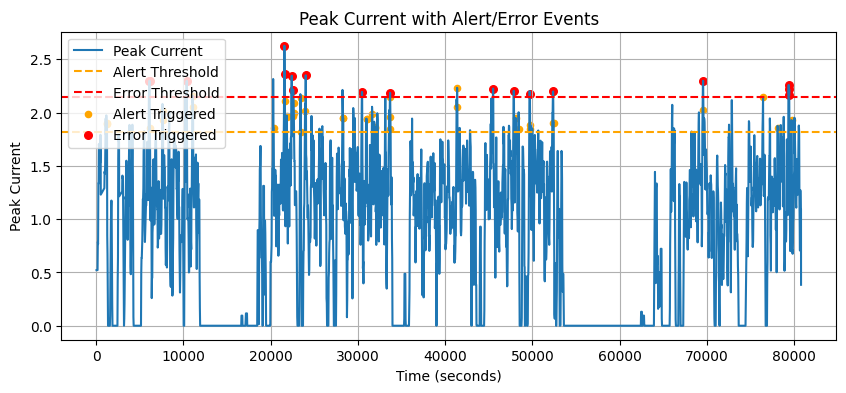

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.plot(peaks_df["window_end_time"], peaks_df["peak_current"], label="Peak Current")

# Thresholds
plt.axhline(MinC, color="orange", linestyle="--", label="Alert Threshold")
plt.axhline(MaxC, color="red", linestyle="--", label="Error Threshold")

# Alert points
alert_times = peaks_df.loc[peaks_df["Alert"], "window_end_time"]
alert_vals = peaks_df.loc[peaks_df["Alert"], "peak_current"]

error_times = peaks_df.loc[peaks_df["Error"], "window_end_time"]
error_vals = peaks_df.loc[peaks_df["Error"], "peak_current"]

plt.scatter(alert_times, alert_vals, color="orange", s=20, label="Alert Triggered")
plt.scatter(error_times, error_vals, color="red", s=30, label="Error Triggered")

plt.xlabel("Time (seconds)")
plt.ylabel("Peak Current")
plt.title("Peak Current with Alert/Error Events")
plt.legend()
plt.grid(True)
plt.show()


## 🌐9. ETA (Estimated Time to Threshold)

At each new **peak** (30s), take the last **K peaks** and fit a line:

$$peak(i) \approx a \cdot i + b$$

If $a$ (slope) $> 0$, then the signal is rising.

The time when it crosses $MaxC$ is:

$$t_{cross} = \frac{MaxC - b}{a}$$

Then:

$$ETA = t_{cross} - t_{now}$$

**Trigger Early Warning if:**

- $a > 0$
- $0 < ETA \leq 3600$

In [23]:
from src.stream_monitor import EarlyWarningEngine

ew = EarlyWarningEngine(maxc=MaxC, k=20, horizon_sec=1209600, min_slope=1e-7, cooldown_windows=20)

### Real-Time Streaming Simulation

This section demonstrates how the system would operate in a real-world production environment. We simulate:

1. **Data Collection**: Continuous polling from the database to retrieve new telemetry data
2. **Live Processing**: Real-time peak extraction and threshold monitoring
3. **Early Warning System**: Proactive alerts triggered **before** critical failures occur
4. **Visualization**: Dynamic plotting to monitor system health in real-time

The playback simulation mimics streaming data from the robot, enabling us to test alert mechanisms and visualize how warnings would be issued during actual operation.

In [15]:
%matplotlib inline

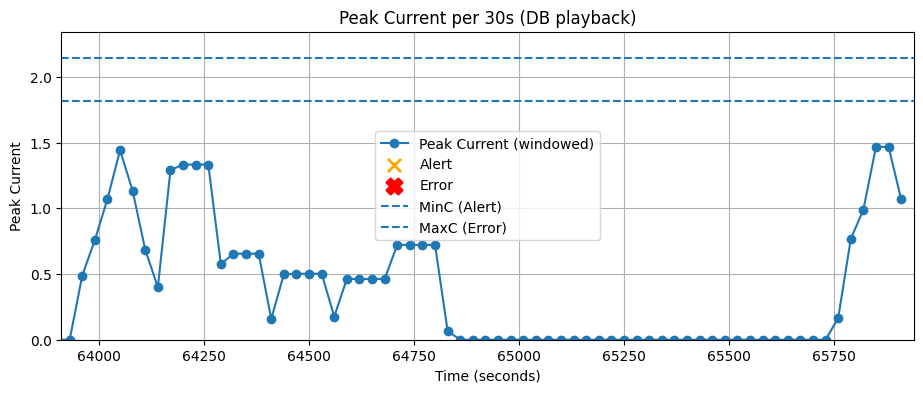

In [ ]:
import os
from src.stream_monitor import DBPoller, PeakWindowAggregator, AlertEngine, LivePlotter, run_playback

# 1) Config
import yaml

# Caminho para o arquivo de configuração
config_path = "../configs/experiment_config.yaml"

# Carregar o arquivo YAML
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

# Obter a URL do banco de dados
db_url = config.get("database", {}).get("db_url")

# 2) Components
poller = DBPoller(
    db_url=db_url,
    table="robot_telemetry",
    id_col="id",
    time_col="elapsed_seconds",
    value_col="axis1_smooth",
)

aggregator = PeakWindowAggregator(window_size_sec=30.0)
alerter = AlertEngine(minc=MinC, maxc=MaxC, t_alert=3, t_error=2)
plotter = LivePlotter(minc=MinC, maxc=MaxC, title="Peak Current per 30s (DB playback)")

# 3) Run playback (1 row per second)
run_playback(
    poller=poller,
    aggregator=aggregator,
    alerter=alerter,
    plotter=plotter,
    rows_per_tick=50,     # how many DB rows per "tick"
    tick_seconds=1.0,    # 1 second per tick
    start_last_id=0
)
